In [1]:
%load_ext autoreload
%autoreload 2

# Orthogonality of our sponge circuit components to sRNA network

The circuit is composed of a synthetic sRNA and two fluorescent proteins mRNA's, cyRFP and EGFP.

## Imports

In [2]:
import os
import pandas as pd
import re
import logging 

from synbio_morpher.srv.io.manage.script_manager import script_preamble
from synbio_morpher.srv.parameter_prediction.IntaRNA.bin.copomus.IntaRNA import IntaRNA
from synbio_morpher.srv.parameter_prediction.simulator import process_raw_stdout
from synbio_morpher.utils.circuit.common.config_setup import retrieve_default_args, load_simulator_kwargs
from synbio_morpher.utils.common.setup import prepare_config, expand_config
from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict
from synbio_morpher.utils.data.data_format_tools.manipulate_fasta import load_seq_from_FASTA, write_fasta_file
from synbio_morpher.utils.misc.numerical import count_monotonic_group_lengths, find_monotonic_group_idxs
from synbio_morpher.utils.misc.string_handling import string_to_tuple_list
from synbio_morpher.utils.misc.type_handling import get_nth_elements, flatten_listlike

from subprocess import Popen, PIPE, run
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import jax



/home/wadh6511/Kode/env_evo/lib/python3.10/site-packages/jaxtyping/__init__.py:221: UserWarning: jaxtyping version >=0.2.23 should be used with Equinox version >=0.11.1
  warnings.warn(


# Load data

Load the sequences for EGFP and cyRFP, along with synthetic ChiX and the other sRNA's.

In [3]:
fn_tus = os.path.join('..', 'data', 'sRNA', 'EcoCyc', 'EcoCyc_TUs_DH10B.csv')
fn_srnas = os.path.join('..', 'data', 'sRNA', 'EcoCyc', 'EcoCyc_regulatory_RNAs_DH10B.csv')
fn_merged = os.path.join('..', 'data', 'sRNA', 'merged_EcoCyc_RNAInter_sRNATarBase.csv')
fn_inter = os.path.join('..', 'data', 'sRNA', 'merged_inter.csv')
d_tus = pd.read_csv(fn_tus, index_col=0)
d_srnas = pd.read_csv(fn_srnas, index_col=0)
d_merged = pd.read_csv(fn_merged, index_col=0)
d_inter = pd.read_csv(fn_inter, index_col=0)

fn_fps = 'data/fps.fasta'
fn_muts = 'data/scott_mutations.fasta'
muts = load_seq_from_FASTA(fn_muts, as_type='dict')
fps = load_seq_from_FASTA(fn_fps, as_type='dict')

## Get new syntheses

In [4]:
sdir = 'February 2024 synthesis'

all_synths = {}
for f in os.listdir(sdir): 
    syn = load_seq_from_FASTA(os.path.join(sdir, f), as_type='dict')
    all_synths.update(syn)
    
all_synths

{'double_seed_NT_mScarlet-I': 'GGTCTCAGTACAGCGCTCAACGGGTGTGCTTCCCGTTCTGATGAGTCCGTGAGGACGAAAGCGCCTCTACAAATAATTTTGTTTAAacttcctgagccggaacgaaaagttttatcggaatgcgtgttctgatgggcttttggcttacggtATAAGGAGTCCGGTGTAGCGAAAGcaattggtctgcgattcagaccacggtagcgagactaccctttttcCACTGCCTCGCCCTTGCTCACCAtacatttaccctGAAACATTTCGTCCATCTCTAAGAatagtgattaatgtagcaccgccatattgcggtgcttttttttTCGAAGAGACC',
 'sRNA_mScarlet-I_alternative': 'ACAGATCGTCAAGATTAGAAAACGGTAGCAGCATTATCGGAGGTTCTCTAACTAGTGGTCTCAGTACAGCGCTCAACGGGTGTGCTTCCCGTTCTGATGAGTCCGTGAGGACGAAAGCGCCTCTACAAATAATTTTGTTTAAACACCGTCGCTTAAAGTGACGGCATAATAATAAAAAAATGAAATTCCATGTGCACCTTGAACCGGCCAATAGCGATATTGGCCATTTTTTTTCGAAGAGACCATGGATAGCCGTGTCTTCACTGTGCTGCGGCTACCCATCGCCTGAAAACCAGTTGG',
 'MicC': 'TCTACGCAGCGACATGTTTATTAACAGTTGTCTGGCAGCACAAAACTGGTCTCAGTACAGTAGTCACCGGCTGTGCTTGCCGGTCTGATGAGCCTGTGAAGGCGAAACTACCTCTACAAATAATTTTGTTTAACTCGAGAAAAAAAGCCCGGACGACTGTTCGGGCTTGTCTTTTTATATGTTGGAAAATCAGTGGCAATGCAATGGCCCAACAGAAAATGCGTAAAGGAGAAGAACTTTTCCATAAGAGACCTTTACCATGGTCGTAGAAGCCCCCCAGAGTTAG

## Select sRNAs from database

In [5]:
to_remove = ['e14 prophage; ', 'Qin prophage; ', 'Rac prophage; ', 
             'putative antitoxin ', 'antisense regulatory RNA ', 'small antisense RNA ',
             'antitoxin ', 'small regulatory RNA ', 
             'putative antisense regulatory RNA ', 'small regulatory RNA antitoxin ', 'small RNA ']

for r in to_remove:
    d_srnas['Common-Name'] = d_srnas['Common-Name'].str.replace(r, '')

In [6]:
targets = dict(zip(d_srnas['Common-Name'].to_list(), d_srnas['Sequence - DNA sequence']))

# Run IntaRNA

May need to put all the sRNA's into one fasta.

In [7]:
top_dir = 'data/16_orthogonality_synthetics'
fn_query = os.path.join('query.fasta')
fn_targets = os.path.join('targets.fasta')

write_fasta_file(out_path=fn_query, data=all_synths, byseq=True)
write_fasta_file(out_path=fn_targets, data=targets, byseq=True)


In [8]:
run_intarna = False

config = {
    "experiment": {
        "purpose": "tests",
    },
    "system_type": "RNA",
    "interaction_simulator": {
        "name": "IntaRNA",
        "postprocess": True,
        "simulator_kwargs": {
                "outcsvcols": "id1, id2, E, E_norm, bpList, hybridDPfull, seedPu1, seedPu2, seedStart1, seedStart2, seedEnd1, seedEnd2",
                "threads": 6,
                "n": 1,
                "raw_stdout": True
        }
    },
    "molecular_params": {
        "avg_mRNA_per_cell": 100,
        "cell_doubling_time": 1200,
        "creation_rate": 2.35,
        "starting_copynumbers": 200,
        "degradation_rate": 0.01175,
        "association_binding_rate": 1000000
    }
}


if run_intarna:
    data_writer = None
    config, data_writer = script_preamble(config, data_writer)
    config = prepare_config(expand_config(config=config))

    os.rmdir(data_writer.top_write_dir)
    data_writer.top_write_dir = top_dir
    data_writer.reset_ensemble()
    data_writer.unsubdivide()

In [9]:

def simulate_IntaRNA_local(fn_query: str,
                           fn_targets: str,
                           sim_kwargs={}):
    sim_kwargs['query'] = fn_query
    sim_kwargs['target'] = fn_targets

    def run(query: str, target: str, qidxpos0: int, tidxpos0: int, outcsvcols: str, threads: int, n: int = 1,
            param_file: str = '', extra_params: list = [], raw_stdout: bool = False):
        p = Popen(['IntaRNA', '-q', query, '-t', target,
                   '--outMode=C', f'--outcsvcols={outcsvcols}',
                   f'--qIdxPos0={qidxpos0}',
                   f'--tIdxPos0={tidxpos0}',
                   f'--outNumber={n}',
                   f'--threads={threads}', param_file]
                  + extra_params, stdout=PIPE, stderr=PIPE, universal_newlines=True)
        stdout, stderr = p.communicate()
        return process_raw_stdout(stdout)

    return run(**sim_kwargs)


if run_intarna:

    sim_data = simulate_IntaRNA_local(fn_query=fn_query,
                                      fn_targets=fn_targets,
                                      sim_kwargs=config['interaction_simulator']['simulator_kwargs'])

    data_writer.output(data=sim_data, out_type='json',
                       out_name='inter_data_raw', overwrite=True)
    print(data_writer.write_dir)

## Load back in

In [10]:
sim_data_l = load_json_as_dict('data/16_orthogonality_synthetics/inter_data_raw.json')
# for k, v in sim_data_l.items():
#     sim_data_l[k] = list(v.values())

default_vals = {
    'id1': '', 'id2': '', 'E': 0.0, 'E_norm': 0.0, 'bpList': '', 'hybridDPfull': '', 'seedPu1': '', 'seedPu2': '', 'seedStart1': '', 'seedStart2': '', 'seedEnd1': '', 'seedEnd2': '', 'subseqDB': '', 'Pu1': 0.0, 'Pu2': 0.0
}
for s, v in sim_data_l.items():            
    if len(v.values()) < len(all_synths):
        diffs = set(all_synths.keys()) - set(v.keys())
        for d in diffs:
            sim_data_l[s][d] = default_vals

In [11]:
np.array([[float(vv['E']) for vv in v.values()] for v in sim_data_l.values()]).T

array([[ -2.25,  -3.76,  -6.81, ...,  -4.71,  -7.03,  -8.54],
       [ -2.74,  -3.79,  -8.76, ...,  -1.67,  -3.78,  -5.83],
       [ -7.9 ,  -5.83,  -4.57, ...,  -1.68,  -7.67,  -4.88],
       ...,
       [ -1.12,  -2.84,  -8.41, ...,  -4.33,  -2.62,  -4.83],
       [ -6.68,  -5.57,  -6.6 , ...,  -2.54, -10.41,  -5.67],
       [ -1.46,  -4.23,  -6.22, ...,  -4.05,  -8.57,  -5.98]])

# Visualise

Text(0.5, 1.0, 'Binding energy between constructs (y-axis) and sRNAs (x-axis) (kcal/mol)')

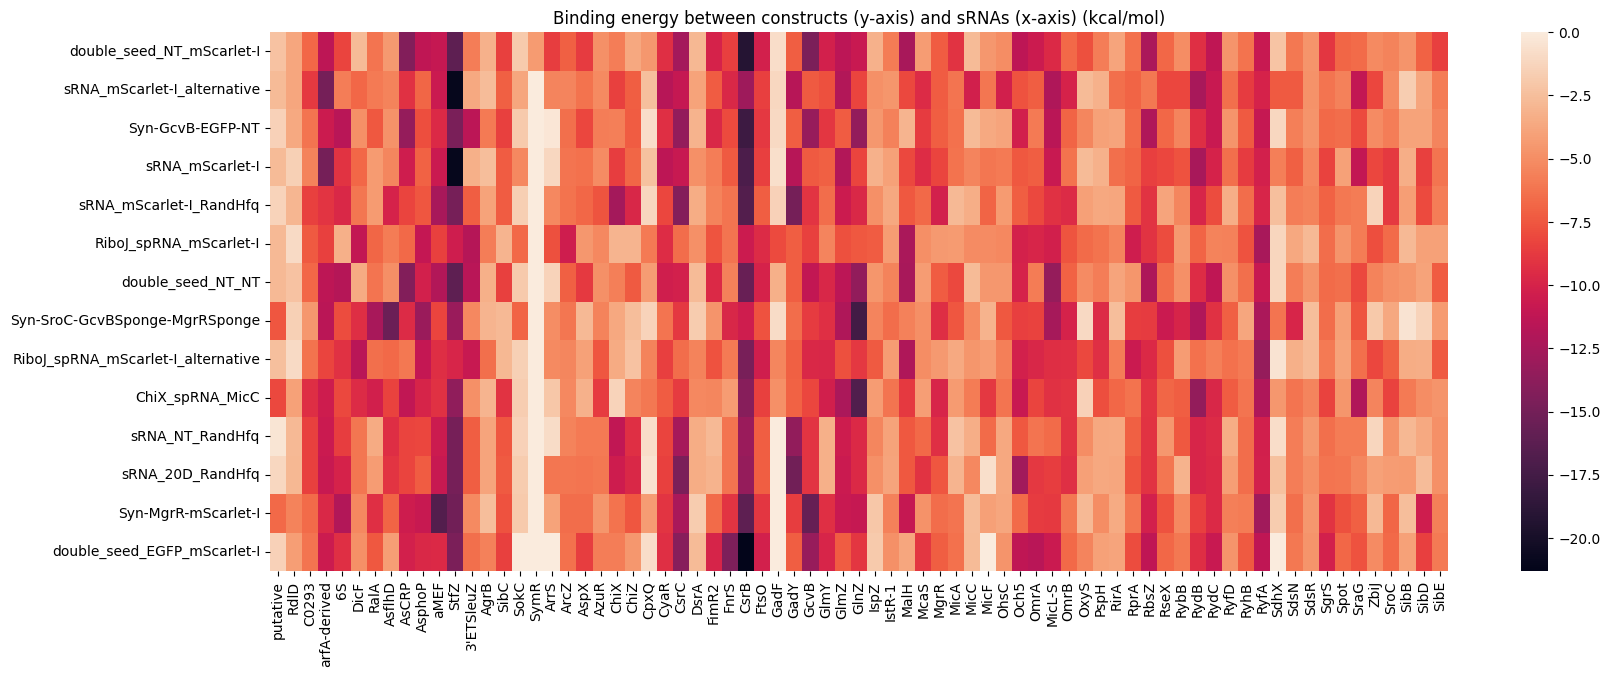

In [26]:
energies = pd.DataFrame(data=np.array([[float(vv['E']) for vv in v.values()] for v in sim_data_l.values()]).T,
                        columns=sim_data_l.keys(), index=list(list(sim_data_l.values())[0].keys()))
energies = energies.drop(labels='MicC')

fig = plt.figure(figsize=(19, 7))
sns.heatmap(energies)
plt.title('Binding energy between constructs (y-axis) and sRNAs (x-axis) (kcal/mol)')

In [21]:
sim_data_l['6S']['ChiX_spRNA_MicC']

{'id1': '6S',
 'id2': 'ChiX_spRNA_MicC',
 'E': '-8.09',
 'E_norm': '-0.741299',
 'bpList': '(31,198):(32,197):(34,195):(35,194):(36,193):(39,190):(40,189):(43,186):(44,185):(45,184):(46,183):(47,182):(48,181):(49,180):(50,179):(51,178)',
 'hybridDPfull': '..............................((.(((..((..(((((((((....................................................................................................................................&.................................................................................................................................................................................)))))))))..))..))).))......................................................................................................',
 'seedPu1': '0.39659365042262729:0.37167169996621929:0.38393050966078013',
 'seedPu2': '0.26867557106797529:0.23982928955321148:0.25591072290631295',
 'seedStart1': '45:43:44',
 'seedStart2': '178:180:179',
 'seedEnd1': '51:49:50',
 'seedEnd2': '184:186:185

Text(0.5, 1.0, 'sRNA Interference on new synthesis, DH10B sRNAs')

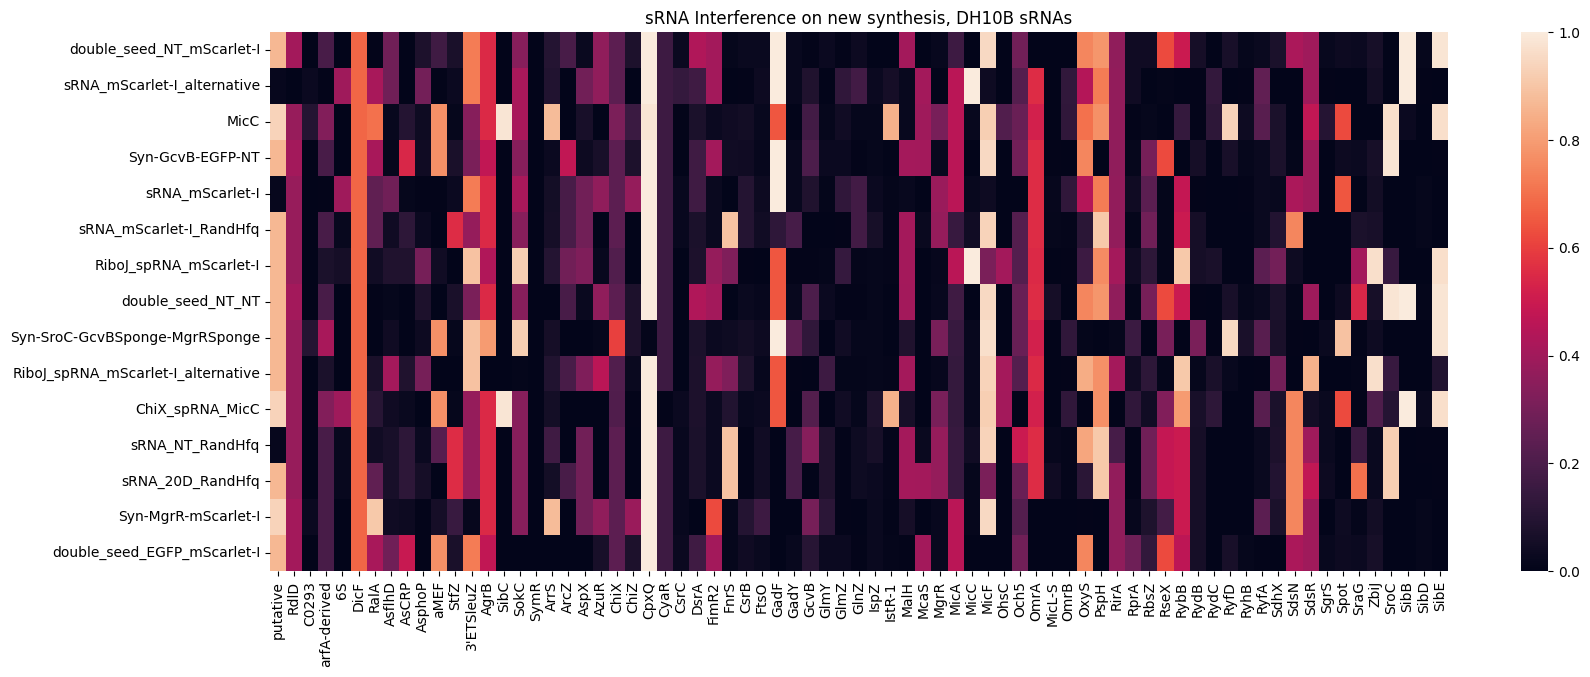

In [23]:
pu1s = pd.DataFrame(data=np.array([[float(vv['seedPu1'].split(':')[0]) if vv['seedPu1'].split(':')[0] else 0 for vv in v.values()] for v in sim_data_l.values()]).T,
                        columns=sim_data_l.keys(), index=list(list(sim_data_l.values())[0].keys()))

fig = plt.figure(figsize=(19, 7))
sns.heatmap(pu1s)
plt.title('sRNA Interference on new synthesis, DH10B sRNAs')